In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import json
from typing import List, Tuple

print('OpenCV Version: ', cv2.__version__)

OpenCV Version:  4.3.0


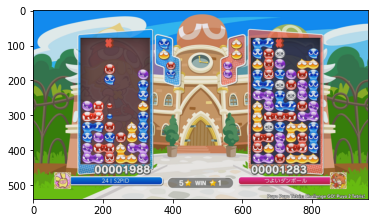

In [116]:
im = Image.open('test-images/amitie_witch.png')
im = im.resize((im.width // 2, im.height // 2))
im = np.array(im)[...,:3]
plt.imshow(im)

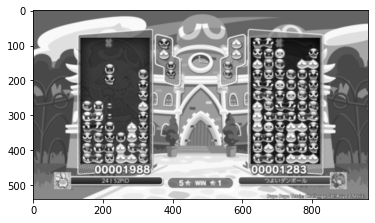

In [117]:
im_gray = np.dot(im[...,:3], [0.2989, 0.5870, 0.1140])
im_gray = im_gray.astype(np.uint8)
im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)

plt.imshow(im_gray, cmap='gray')

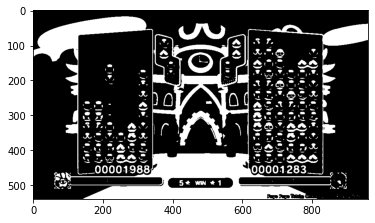

In [118]:
# Get a mask for dark regions
mask = np.zeros_like(im_gray)
mask[im_gray > 180] = 255
plt.imshow(mask, cmap='gray')
plt.show()

[25.5, 52.0, 34.0, 118.0, 117.0, 117.0, 117.0, 52.0, 34.0, 52.0, 34.0, 58.0, 117.0, 117.0, 117.0, 117.0, 59.0, 2.0, 4.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 34.0, 556.5, 563.0, 59.0, 59.0, 1592.5, 59.0, 10.0, 456.0, 5284.0, 27.5, 26.5, 195.5, 10.0, 20.5, 232.5, 4.0, 2.0, 19.0, 36363.5, 1367.5, 1372.0, 4779.0, 18.0, 19.0, 8760.5, 8.5, 6496.5, 6595.5, 302.0]
59


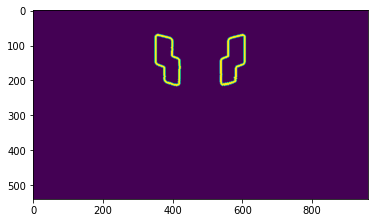

In [120]:
contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
# Keep inner contours
hierarchy = hierarchy.reshape(-1, 4)
top_inds = np.argwhere(hierarchy[:, 3] != -1).reshape(-1)
contours = [contours[i] for i in top_inds]
hierarchy = hierarchy[top_inds]

# Manual Analysis
mask_copy = np.zeros_like(mask)
areas = [cv2.contourArea(contour) for contour in contours]
print(areas)
print(len(areas))
cv2.drawContours(mask_copy, contours, 57, 128, 5) # Player 1
cv2.drawContours(mask_copy, contours, 56, 128, 5) # Player 2
plt.imshow(mask_copy, cmap='viridis')

In [79]:
# Get HuMoments of each contour
moments = [cv2.HuMoments(cv2.moments(contour)).reshape(-1) for contour in contours]
moments = np.array(moments)

# Log Transform the Hu Moments
log_moments = -1 * np.copysign(np.ones_like(moments), moments) * np.log(np.abs(moments))

print(log_moments[56:58])

[[  1.34064576   3.22079494   9.48746706  10.9780034   21.34949681
   12.98130832 -21.91945195]
 [  1.34353595   3.23119674   9.34675268  10.74118381  20.87653262
   12.61612858  21.67993426]]


In [121]:
# Contours for known moments
p1_next_contour = contours[57]
p2_next_contour = contours[56]

contour_data = {
    'p1_next': p1_next_contour.tolist(),
    'p2_next': p2_next_contour.tolist()
}

with open('next_window.json', 'w') as outfile:
    json.dump(contour_data, outfile)

In [129]:
next_window_data = json.load(open('next_window.json'))
p1_next_contour = np.array(next_window_data['p1_next'])
p2_next_contour = np.array(next_window_data['p2_next'])

# Find the lowest 2 inds across the p1 matches and p2 matches. They should overlap to produce only 2 values
contour_ind_set = set()
p1_next_matches = [cv2.matchShapes(p1_next_contour, contour, cv2.CONTOURS_MATCH_I1, 0) for contour in contours]
partition = np.argpartition(p1_next_matches, 1)
contour_ind_set.add(partition[0])
contour_ind_set.add(partition[1])

p2_next_matches = [cv2.matchShapes(p2_next_contour, contour, cv2.CONTOURS_MATCH_I1, 0) for contour in contours]
partition = np.argpartition(p2_next_matches, 1)
contour_ind_set.add(partition[0])
contour_ind_set.add(partition[1])

contour_ind_set = list(contour_ind_set)

contour0 = contours[contour_ind_set[0]]
contour1 = contours[contour_ind_set[1]]
contour0_min_x = np.amin(np.array(contour0).reshape(-1, 2)[:, 0])
contour1_min_x = np.amin(np.array(contour1).reshape(-1, 2)[:, 0])

# Contour on the left is p1, contour on the right is p2
if contour0_min_x < contour1_min_x:
    p1_next = contour0
    p2_next = contour1
else:
    p1_next = contour1
    p2_next = contour0

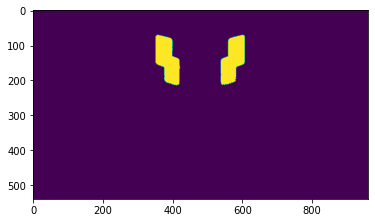

In [130]:
mask_copy = np.zeros_like(mask)
cv2.drawContours(mask_copy, [p1_next], 0, 128, -1)
cv2.drawContours(mask_copy, [p2_next], 0, 128, -1)
plt.imshow(mask_copy, cmap='viridis')

### Check if this generalizes to different screens

In [133]:
next_window_data = json.load(open('next_window.json'))
p1_next_contour = np.array(next_window_data['p1_next'])
p2_next_contour = np.array(next_window_data['p2_next'])

def next_window_contours(im, p1_next_contour=p1_next_contour, p2_next_contour=p2_next_contour):
    # Grayscale and blur
    im_gray = np.dot(im[...,:3], [0.2989, 0.5870, 0.1140])
    im_gray = im_gray.astype(np.uint8)
    im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)

    # Get a mask for light regions
    mask = np.zeros_like(im_gray)
    mask[im_gray > 200] = 255

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    # Keep inner contours
    hierarchy = hierarchy.reshape(-1, 4)
    top_inds = np.argwhere(hierarchy[:, 3] != -1).reshape(-1)
    contours = [contours[i] for i in top_inds]
    hierarchy = hierarchy[top_inds]

    # use cv2.matchShapes to compare Hu Moments
    # Find the lowest 2 inds across the p1 matches and p2 matches. They should overlap to produce only 2 values
    contour_ind_set = set()
    p1_next_matches = [cv2.matchShapes(p1_next_contour, contour, cv2.CONTOURS_MATCH_I1, 0) for contour in contours]
    partition = np.argpartition(p1_next_matches, 1)
    contour_ind_set.add(partition[0])
    contour_ind_set.add(partition[1])

    p2_next_matches = [cv2.matchShapes(p2_next_contour, contour, cv2.CONTOURS_MATCH_I1, 0) for contour in contours]
    partition = np.argpartition(p2_next_matches, 1)
    contour_ind_set.add(partition[0])
    contour_ind_set.add(partition[1])

    contour_ind_set = list(contour_ind_set)

    contour0 = contours[contour_ind_set[0]]
    contour1 = contours[contour_ind_set[1]]
    contour0_min_x = np.amin(np.array(contour0).reshape(-1, 2)[:, 0])
    contour1_min_x = np.amin(np.array(contour1).reshape(-1, 2)[:, 0])

    # Contour on the left is p1, contour on the right is p2
    if contour0_min_x < contour1_min_x:
        p1_next = contour0
        p2_next = contour1
    else:
        p1_next = contour1
        p2_next = contour0

    return p1_next, p2_next

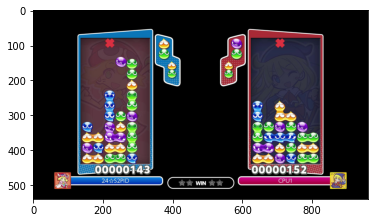

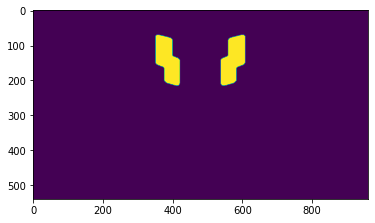

In [134]:
im = Image.open('test-images/amitie_witch3.jpg').convert('RGB')
im = im.resize((im.width // 2, im.height //2))
im = np.array(im)
plt.imshow(im)
plt.show()
p1_next, p2_next = next_window_contours(im)
mask_copy = np.zeros_like(mask)
cv2.drawContours(mask_copy, [p1_next], 0, 128, -1)
cv2.drawContours(mask_copy, [p2_next], 0, 128, -1)
plt.imshow(mask_copy, cmap='viridis')
plt.show()